# Synthetic Data Tutorial

This notebook shows how to process MTH5 data from a synthetic dataset.

It also shows how to modify processing so that Fourier coefficients are saved in the mth5.  These FCs can be used to perform TF estimation using different regression settings.  The same FCs will be used for feature extraction in future (This section is a work in Progress). 

## Contents:

1. [Process Synthetic Data with Aurora](#Process-Synthetic-Data-with-Aurora)
2. [Fourier coefficient storage in MTH5](#Fourier-coefficient-storage-in-MTH5)

## Process Synthetic Data with Aurora

Here is a minimal example of running aurora processing on an mth5 populated with synthetic time series.


Steps:
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

### Here are the modules we will need to import 

In [1]:
import pathlib
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.data.make_mth5_from_asc import create_test12rr_h5
from mth5.data.paths import SyntheticTestPaths
from mth5.processing import RunSummary, KernelDataset

warnings.filterwarnings('ignore')

### Define target folder and mth5 path

By default, the synthetic mth5 file is used for testing in `aurora/tests/synthetic/` and probably already exists on your system if you have run the tests. In the code below, we check if the file exists already, and if not we make it.

**NOTE:** If using a read-only HPC installation, you may not be able to write to the directory where aurora is installed.  In that case, defining your target path as somewhere you have write permission.  In that case, uncommment the READ ONLY INSTALLATION block below.

In [2]:
synthetic_test_paths = SyntheticTestPaths()
target_folder = synthetic_test_paths.mth5_path

## READ ONLY INSTALLATION
# home = pathlib.Path.home()
# target_folder = home.joinpath("aurora_test_folder")
# target_folder.mkdir(parents=True, exist_ok=True)

mth5_path = target_folder.joinpath("test12rr.h5")

If the mth5 doesn't already exist, or you want to re-make it, call `create_test12rr_h5()`

In [3]:
# Uncomment this to start with a fresh mth5 file

# mth5_path.unlink()

In [4]:
if not mth5_path.exists():
    create_test12rr_h5(target_folder=target_folder)   

### Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want.
Run summary takes a list of mth5 paths as input argument.

In [5]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

2026-01-15T21:33:06.823260-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Define a Kernel Dataset


In [6]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

2026-01-15T21:33:07.117739-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config will get its information about the specific stations to process via the kernel dataset.

**NOTE:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [7]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()

2026-01-15T21:33:07.273014-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


### Take a look at the processing configuration

In [8]:
config

{
    "processing": {
        "band_setup_file": "C:\\Users\\peaco\\OneDrive\\Documents\\GitHub\\aurora\\aurora\\config\\emtf_band_setup\\bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "channel_nomenclature.keyword": "default",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.119140625,
                                "frequency_min": 0.095703125,
                                "index_max": 30,
                            

### Call process_mth5

2026-01-15T21:33:07.343785-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-15T21:33:07.355116-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256      39999.0             178.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000           1024.0                 256       9999.0          

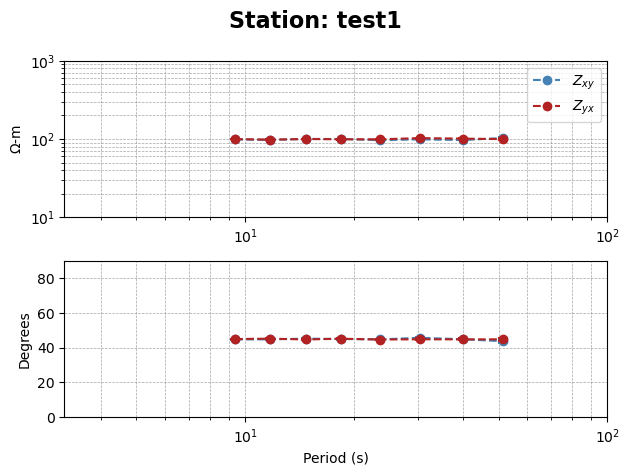

2026-01-15T21:33:20.452804-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 1
2026-01-15T21:33:20.456082-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
2026-01-15T21:33:20.488749-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
2026-01-15T21:33:20.528768-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 1 Successfully
2026-01-15T21:33:20.719180-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-15T21:33:20.719180-0800 | INFO | mt_metadata.processing.fourier_coef

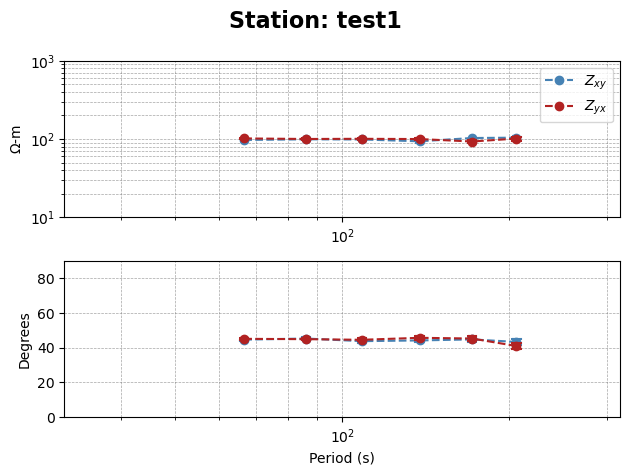

2026-01-15T21:33:23.997028-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 2
2026-01-15T21:33:24.006577-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
2026-01-15T21:33:24.006577-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
2026-01-15T21:33:24.006577-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 2 Successfully
2026-01-15T21:33:24.168650-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-15T21:33:24.168650-0800 | INFO | mt_metadata.processing.fourier_coef

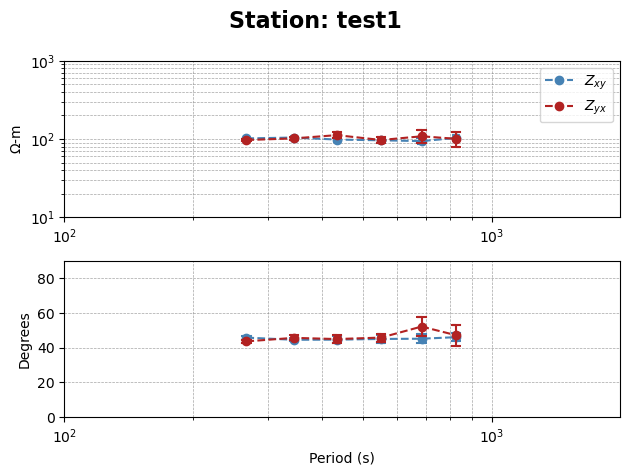

2026-01-15T21:33:27.247620-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 3
2026-01-15T21:33:27.251339-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
2026-01-15T21:33:27.251339-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 147 | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
2026-01-15T21:33:27.251339-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 3 Successfully
2026-01-15T21:33:27.418616-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-15T21:33:27.418616-0800 | INFO | mt_metadata.processing.fourier_coef

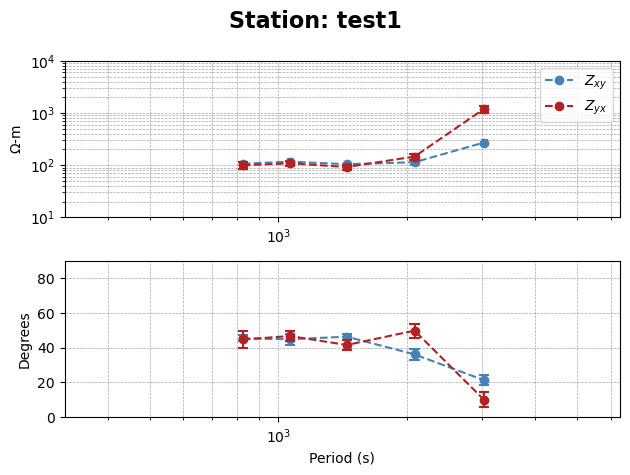

2026-01-15T21:33:30.262221-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 230 | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>
2026-01-15T21:33:30.269265-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5
2026-01-15T21:33:30.269265-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5


In [9]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

### Export TF to a file 

In [10]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write(fn=xml_file_base, file_type="emtfxml")


EMTFXML(station='test1', latitude=18.00, longitude=0.00, elevation=0.00)

In [11]:
edi_file_base = f"synthetic_test1.edi"
tf_cls.write(fn=edi_file_base, file_type="edi")


Station: test1
--------------------------------------------------
	Survey:        EMTF Synthetic
	Project:       
	Acquired by:   
	Acquired date: 1980-01-01T00:00:00+00:00
	Latitude:      17.996
	Longitude:     0.000
	Elevation:     0.000
	Impedance:     True
	Tipper:        True
	Number of periods: 25
		Period Range:   9.36498E+00 -- 3.02940E+03 s
		Frequency Range 3.30098E-04 -- 1.06781E-01 s

<div class="alert alert-block alert-info"> <b>NOTE</b> Fourier coefficient section below here is a work in progress. </div>

## Fourier coefficient storage in MTH5

The capability to store Fourier coeffficients (FCs) in MTH5 is now available.  This will enable some different approaches to processing and data quality control (QC).  The data QC tools are a work in progress. The following examples show how to add some FC levels to an MTH5, providing a starting point for processing or feature extraction from these data.

There are currently two main ways to add FCs to the MTH5.

1. Store on the fly while processing with Aurora
2. Use a dedicated method to make FCs only.

### Storing while processing with Aurora

We can store FCs while processing by changing the processing config's `save_fcs` attribute to True 

If we do that with the current processing config however we encouter a warning:

```
Saving FCs for remote reference processing is not supported 
 - To save FCs, process as single station, then you can use the FCs for RR processing 
 - See issue #319 for details  
 - forcing processing config save_fcs = False 
```

There are two workarounds for this:
1. Process each station as a single station, and then the FCs (TODO: Add an example of this)
2. Explicitly call `add_fcs` function.


In [12]:
file_size_before_adding_fcs = mth5_path.stat().st_size
print(f"file_size_before_adding_fcs: {file_size_before_adding_fcs}")

file_size_before_adding_fcs: 5750906


### Using the "single-station processing method" of FC generation

In [13]:
# set  kernel_dataset to work on one station only
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", None)  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# tell the config to save the FCs
for dec in config.decimations:
    dec.save_fcs = True
    dec.save_fcs_type = "h5"

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()
kernel_dataset.mini_summary

2026-01-15T21:33:32.688273-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5
2026-01-15T21:33:32.837237-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


In [14]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

2026-01-15T21:33:32.875988-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-15T21:33:32.884316-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256      39999.0             178.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000           1024.0                 256       9999.0          

In [15]:
file_size_after_adding_fcs_station_1 = mth5_path.stat().st_size
print(f"file_size_after_adding_fcs_station_1: {file_size_after_adding_fcs_station_1}")

file_size_after_adding_fcs_station_1: 5753322


In [16]:
# Now the other station

# set  kernel_dataset to work on one station only
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test2", None)  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# tell the config to save the FCs
for dec in config.decimations:
    dec.save_fcs = True
    dec.save_fcs_type = "h5"



2026-01-15T21:33:46.528815-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5
2026-01-15T21:33:46.645716-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [17]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

2026-01-15T21:33:46.680809-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-15T21:33:46.685472-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test2  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256      39999.0             178.0
1   39999.0      True      40000  001   test2  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000           1024.0                 256       9999.0          


Now, the FCs are there (for the specific processing configuration).

If you were to re-process the data, the FCs are already there, 

In [18]:
file_size_after_adding_fcs_station_2 = mth5_path.stat().st_size
print(f"file_size_after_adding_fcs_station_2: {file_size_after_adding_fcs_station_2}")

file_size_after_adding_fcs_station_2: 5755738


In [19]:
# set  kernel_dataset to work on both stations again
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)




2026-01-15T21:34:01.087323-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\data\mth5\test12rr.h5
2026-01-15T21:34:01.218768-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | line: 113 | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [20]:

from aurora.pipelines.transfer_function_kernel import TransferFunctionKernel
tfk = TransferFunctionKernel(dataset=kernel_dataset, config=config)
tfk.update_processing_summary()
tfk.check_if_fcs_already_exist()
tfk.dataset_df

2026-01-15T21:34:01.435531-0800 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | line: 854 | FCs detected -- checking against processing requirements.
2026-01-15T21:34:01.501186-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ey
2026-01-15T21:34:01.501186-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hy
2026-01-15T21:34:01.501186-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: hz
2026-01-15T21:34:01.501186-0800 | INFO | mt_metadata.processing.fourier_coefficients.decimation | validate_channels_consistency | line: 207 | Creating FCChannel for estimated channel: ex
2026-01-15T21:34:01.501186-0800 | INFO | mt_metadata.processing.fourier_coefficien

,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference,fc,remote,run_dataarray,stft,mth5_obj
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",39999.0,1980-01-01 11:06:39+00:00,True,"[hx, hy]",C:/Users/peaco/OneDrive/Documents/GitHub/mth5/...,40000,"[ex, ey, hz]",001,1.0,1980-01-01 00:00:00+00:00,test1,EMTF Synthetic,<HDF5 object reference>,<HDF5 object reference>,True,False,None,None,None
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",39999.0,1980-01-01 11:06:39+00:00,True,"[hx, hy]",C:/Users/peaco/OneDrive/Documents/GitHub/mth5/...,40000,"[ex, ey, hz]",001,1.0,1980-01-01 00:00:00+00:00,test2,EMTF Synthetic,<HDF5 object reference>,<HDF5 object reference>,True,True,None,None,None


In [21]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

2026-01-15T21:34:03.329948-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-15T21:34:03.337332-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None     None         0         1.0     1.000000            256.0                 256      39999.0             178.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None     None         1         4.0     0.250000           1024.0                 256       9999.0          